In [1]:
import numpy as np
import os
import re

In [2]:
class Layer(object):
    def __init__(self):
        pass

    def activate_layer(self):
        pass

    def foreward(self, last_layer_output):
        pass

    def backward(self, next_layer_output):
        pass

    def update(self, learning_rate):
        pass

class Activation(object):
    def __init__(self):
        pass
    
    def activate(self, x):
        pass

    def deriv(self, x):
        pass

class Loss(object):
    def __init__(self):
        pass

    def cal_loss(self, y_pred, y_real):
        pass

    def deriv_loss(self, y_pred, y_reaf):
        pass

In [3]:
class Sigmoid(Activation):
    def activate(self, x):
        x = x.copy()
        x_shape = x.shape
        x = np.array(x).ravel()                                # 铺平
        y = []
        for i in range(len(x)):
            if  x[i] >= 0:
                y.append(1 / (1 + np.exp(-x[i])))
            else:
                y.append(np.exp(x[i]) / (1 + np.exp(x[i])))      # 当某一个元素小于0时，用另一个公式计算，解决上溢问题
        return np.array(y).reshape(x_shape)
    
    def deriv(self, x):
        x = x.copy()
        y = np.multiply(self.activate(x), 1 - self.activate(x))
        return y

class TanH(Activation):
    def activate(self, x):
        x = x.copy()
        y = (np.exp(x) - np.exp(- x)) / (np.exp(x) + np.exp(- x))
        return y
    
    def deriv(self, x):
        x = x.copy()
        y = 1 - np.power(self.activate(x), 2)
        return y

class Relu(Activation):
    def activate(self, x):
        y = x.copy()
        y[y < 0] = 0
        return y
    
    def deriv(self, x):
        y = x.copy()
        y[y < 0] = 0
        y[y >= 0] = 1
        return y

class Softmax(Activation):
    def activate(self, x):
        x = x.copy()
        x = np.exp(x)
        x_sum = np.sum(x, axis=0).reshape((1, -1))
        y = np.divide(x + 1e-7, x_sum + 1e-7)
        return y
    
    def deriv(self, x):
        y = 1  # 配合cross_entrophy使用
        return y

In [4]:
class Cross_Entrophy(Loss):
    def cal_loss(self, y_pred, y_real):
        ls = - np.sum(np.multiply(y_real, np.log(y_pred)))
        return ls
    
    def deriv_loss(self, y_pred, y_real):
        dls = - np.divide(y_real + 1e-7, y_pred + 1e-7)
        return dls

class Softmax_Cross_Entrophy(Cross_Entrophy):
    def deriv_loss(self, y_pred, y_real):
        dz = y_pred - y_real
        return dz

In [5]:
'''
Dense
'''
class Dense(Layer):
    def __init__(self, unit_num, activate_method):
        self.unit_num = unit_num
        self.activation = activate_method
        self.weight = None
        self.bias = None
        self.fore_layer_output = None
        self.z = None
        self.layer_activation = False
    
    def activate_layer(self, input_shape):
        input_shape = [int(x) for x in input_shape]
        self.weight = np.random.randn(self.unit_num, input_shape[0])
        self.bias = np.random.randn(self.unit_num, 1)
        self.layer_activation = True
        return (self.unit_num, )
    
    def foreward(self, input_tensor):
        self.fore_layer_output = input_tensor.copy()
        input_tensor = input_tensor.copy()
        self.z = np.dot(self.weight, input_tensor) + self.bias  # wi*bs
        a = self.activation.activate(self.z)
        return a
    
    def backward(self, input_tensor, trainable=True, learning_rate=0.01):
        input_tensor = input_tensor.copy()
        dz = np.multiply(self.activation.deriv(self.z), input_tensor)
        output_tensor = np.dot(self.weight.T, dz)
        if trainable:
            self.update(dz, learning_rate)
        return output_tensor
    
    def update(self, dz, learning_rate):
        dz = dz.copy()
        w_grad = np.dot(dz, self.fore_layer_output.T)
        b_grad = np.sum(dz, axis=1).reshape(self.bias.shape)
        self.weight -= learning_rate * w_grad
        self.bias -= learning_rate * b_grad

In [29]:
# class Conv(Layer):
#     def __init__(self, filter_num, filter_shape, step=1, padding=None):
#         self.filter = np.random.randn(filter_num, filter_shape[0], filter_shape[1])
#         self.filter_num = filter_num
#         self.step = step
#         self.forward_mat = None
#         self.backward_mat = None
#         self.padding = padding
#         if self.padding is None:
#             self.padding = (self.filter.shape[1] - 1) // 2
    
#     def convolve(self, x, filter, step):
#         mat_height, mat_width = x.shape
#         filter_height, filter_width = filter.shape
#         h_range = np.arange(0, mat_height - filter_height + 1, step)
#         w_range = np.arange(0, mat_width - filter_width + 1, step)
#         y = np.zeros((len(h_range), len(w_range)))
#         for h in h_range:
#             for w in w_range:
#                 sub_x = x[h:h+filter_height, w:w+filter_width]
#                 y[h][w] = np.sum(np.multiply(sub_x, filter))
#         return y

#     def activate_layer(self, input_shape):  # 卷积中输入是4 dimension，忽略bs后是3 dimension
#         output_height = (input_shape[1] + 2*self.padding - self.filter.shape[1] + 1) // \
#             self.step + min(1, (input_shape[1] + 2*self.padding - self.filter.shape[1] + 1) % \
#             self.step)
#         output_width = (input_shape[2] + 2*self.padding - self.filter.shape[2] + 1) // \
#             self.step + min(1, (input_shape[2] + 2*self.padding - self.filter.shape[2] + 1) % \
#             self.step)
#         return (input_shape[0] * self.filter_num, output_height, output_width)

#     def pad(self, image_mat):
#         return np.pad(image_mat, self.padding)[self.padding:- self.padding]  # 使用numpy.pad函数进行padding
    
#     def foreward(self, images_mats):  # 4 dimension
#         self.forward_mat = []
#         images_convoluteds = []
#         for image_mats in images_mats:
#             image_mats = self.pad(image_mats)  # padding
#             self.forward_mat.append(image_mats)
#             image_convoluteds = []
#             for image_mat in image_mats:
#                 height = (image_mat.shape[0] - self.filter.shape[1]) // self.step + 1
#                 width = (image_mat.shape[1] - self.filter.shape[2]) // self.step + 1
#                 image_convoluted = np.zeros((self.filter_num, height, width))
#                 for layer in range(self.filter_num):
#                     for i in range(0, height):
#                         for j in range(0, width):
#                             sub_mat = image_mat[i * self.step : i * self.step + \
#                                 self.filter.shape[1], j * self.step : j * self.step + \
#                                 self.filter.shape[2]]
#                             conved_val = np.sum(np.multiply(sub_mat, self.filter[layer]))
#                             image_convoluted[layer, i, j] = conved_val
#                 image_convoluteds.append(image_convoluted)
#             images_convoluteds.append(np.concatenate(image_convoluteds))
#         images_convoluteds = np.array(images_convoluteds)
#         self.forward_mat = np.array(self.forward_mat)
#         return images_convoluteds
    
#     def backward(self, images_mats, trainable=True, learning_rate=0.01):
#         self.received_backward_mat = images_mats.copy()
#         images_mats = images_mats.copy()
#         images_backward_mats = []
#         for image_mats in images_mats:
#             backward_mats = []
#             for layer_fore in range(self.forward_mat.shape[1]):
#                 backward_mat = np.zeros(self.forward_mat.shape[2:])  # 每一个image和filter对应的2d matrix
#                 for layer_back in range(layer_fore * self.filter_num, (layer_fore + 1) * \
#                     self.filter_num):
#                     image_mat = image_mats[layer_back]
#                     filter_i = layer_back % self.filter.shape[0]
#                     for i in range(image_mat.shape[0]):
#                         for j in range(image_mat.shape[1]):
#                             backward_mat[i * self.step : i * self.step + self.filter.shape[1], \
#                                 j * self.step : j * self.step + self.filter.shape[2]] += \
#                                 image_mat[i, j] * self.filter[filter_i]
#                 backward_mat = backward_mat[self.padding:backward_mat.shape[0] - self.padding, \
#                     self.padding:backward_mat.shape[1] - self.padding]
#                 backward_mats.append(backward_mat)
#             images_backward_mats.append(np.array(backward_mats))
#         images_backward_mats = np.array(images_backward_mats)
#         if trainable:
#             self.update(learning_rate)
#         return images_backward_mats
    
#     def update(self, learning_rate=0.01):
#         filter_grad = {filter_i:np.zeros(self.filter.shape[1:]) for filter_i in range(self.filter_num)}
#         for image_i, backward_mats in enumerate(self.received_backward_mat):
#             for backward_mat_i, backward_mat in enumerate(backward_mats):
#                 filter_i = backward_mat_i % self.filter_num
#                 grad = np.zeros(self.filter.shape[1:])
#                 foreward_mat = self.forward_mat[image_i, backward_mat_i // self.filter_num]
#                 for i in range(grad.shape[0]):
#                     for j in range(grad.shape[1]):
#                         sub_for_mat_h = np.arange(i, foreward_mat.shape[0] - \
#                             self.filter.shape[1] + i + 1, self.step)
#                         sub_for_mat_w = np.arange(j, foreward_mat.shape[1] - \
#                             self.filter.shape[2] + j + 1, self.step)
#                         sub_for_mat = foreward_mat[sub_for_mat_h][:, sub_for_mat_w]
#                         grad[i, j] += np.tensordot(sub_for_mat, backward_mat)
#                 filter_grad[filter_i] += grad
        
#         for filter_i, filter in enumerate(self.filter):
#             self.filter[filter_i] -= learning_rate * filter_grad[filter_i]

class Conv(Layer):
    def __init__(self, filter_num, filter_shape, step=1, padding=None):
        self.filter = np.random.randn(filter_num, filter_shape[0], filter_shape[1])
        self.filter_num = filter_num
        self.step = step
        self.foreward_mat = None
        self.backward_mat = None
        self.padding = padding
        if self.padding is None:
            self.padding = (self.filter.shape[1] - 1) // 2
    
    def activate_layer(self, input_shape):  # 卷积中输入是4 dimension，忽略bs后是3 dimension
        output_height = (input_shape[1] + 2*self.padding - self.filter.shape[1] + 1) // \
            self.step + min(1, (input_shape[1] + 2*self.padding - self.filter.shape[1] + 1) % \
            self.step)
        output_width = (input_shape[2] + 2*self.padding - self.filter.shape[2] + 1) // \
            self.step + min(1, (input_shape[2] + 2*self.padding - self.filter.shape[2] + 1) % \
            self.step)
        return (input_shape[0] * self.filter_num, output_height, output_width)

    def pad(self, x):
        return np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)))  # 使用numpy.pad函数进行padding
    
    def convolve(self, x, filter, step):
        mat_height, mat_width = x.shape
        filter_height, filter_width = filter.shape
        h_range = np.arange(0, mat_height - filter_height + 1, step)
        w_range = np.arange(0, mat_width - filter_width + 1, step)
        y = np.zeros((len(h_range), len(w_range)))
        for h in h_range:
            for w in w_range:
                sub_x = x[h:h+filter_height, w:w+filter_width]
                y[h][w] = np.sum(np.multiply(sub_x, filter))
        return y

    def foreward(self, xs_mats):  # 4 dimension
        self.os = xs_mats.copy()  # 未padding
        xs_mats = self.pad(xs_mats)
        ys_mats = []
        for x_mats in xs_mats:
            y_mats = []
            for x_mat in x_mats:
                for filter in self.filter:
                    y_mats.append(self.convolve(x_mat, filter, self.step))
            y_mats = np.array(y_mats)
            ys_mats.append(y_mats)
        ys_mats = np.array(ys_mats)
        return ys_mats
    
    def backward(self, xs_mats, trainable=True, learning_rate=0.01):
        self.dcs = xs_mats.copy()
        xs_mats = self.pad(xs_mats)
        ys_mats = np.zeros(self.os.shape)
        for x_i, x_mats in enumerate(xs_mats):
            y_height, y_width = ys_mats.shape[2:]  # y矩阵的大小
            for mat_i, x_mat in enumerate(x_mats):
                y_i =  mat_i // self.filter_num  # 第i个y的矩阵
                flipped_filter = np.flip(self.filter[mat_i % self.filter_num])  # 旋转180度
                filter_height, filter_width = flipped_filter.shape
                for y_h in range(y_height):
                    for y_w in range(y_width):
                        sub_x = x_mat[y_h * self.step:y_h * self.step + filter_height, \
                            y_w * self.step:y_w * self.step + filter_width]
                        ys_mats[x_i][y_i][y_h][y_w] += np.tensordot(flipped_filter, sub_x)
        if trainable:
            self.update(learning_rate)
        return ys_mats
    
    def update(self, learning_rate=0.01):
        filter_grad = np.zeros(self.filter.shape)
        os = self.pad(self.os)
        filter_height, filter_width = self.filter.shape[1:]
        o_height, o_width = os.shape[2:]
        for image_i, image_dcs in enumerate(self.dcs):
            for mat_i, mat in enumerate(image_dcs):
                o_i = mat_i // self.filter_num
                filter_i = mat_i % self.filter_num
                for h in range(filter_height):
                    for w in range(filter_width):
                        h_range = np.arange(h, o_height - filter_height + h +1, self.step)
                        w_range = np.arange(w, o_width - filter_width + w + 1, self.step)
                        sub_o = os[image_i][o_i][h_range][:, w_range]
                        filter_grad[filter_i][h, w] += np.tensordot(sub_o, mat)
        
        self.filter = self.filter - learning_rate * filter_grad

class Pool(Layer):
    def __init__(self, step):
        self.step = step
        self.foreward_mats = None
        self.input_mat_shape = None
        self.output_mat_shape = None
    
    def activate_layer(self, input_shape):  # input_shape: 3 dimension
        self.input_mat_shape = list(input_shape[1:])
        output_height = np.ceil(input_shape[1] / self.step)
        output_width = np.ceil(input_shape[2] / self.step)
        self.output_mat_shape = [int(output_height), int(output_width)]
        return (input_shape[0], output_height, output_width)

    def foreward(self, xs_mats):  # 4 dimension
        self.os = xs_mats.copy()
        self.foreward_mats = np.zeros(self.os.shape)
        ys_mats = np.zeros(list(xs_mats.shape[:2]) + self.output_mat_shape)  # 4 dimension
        for image_i, image_mats in enumerate(xs_mats):
            for mat_i, image_mat in enumerate(image_mats):
                height_range = np.arange(0, image_mat.shape[0], self.step)
                width_range = np.arange(0, image_mat.shape[1], self.step)
                for h_i, h in enumerate(height_range):
                    for w_i, w in enumerate(width_range):
                        sub_mat = image_mat[h:h + self.step, w:w + self.step]
                        sub_mat_h, sub_mat_w = sub_mat.shape
                        ys_mats[image_i][mat_i][h_i, w_i] = np.max(sub_mat)
                        max_index = np.argmax(sub_mat)
                        max_h = max_index // sub_mat_w
                        max_w = max_index % sub_mat_w
                        self.foreward_mats[image_i][mat_i][h:h + self.step, w:w + self.step][max_h, max_w] = 1
        return ys_mats

    def backward(self, xs_mats, trainable=True, learning_rate=0.01):
        ys_mats = self.foreward_mats
        for image_i, image_mats in enumerate(xs_mats):
            for layer, image_mat in enumerate(image_mats):
                for h in range(image_mat.shape[0]):
                    for w in range(image_mat.shape[1]):
                        ys_mats[image_i, layer, self.step*h:self.step*(h+1), \
                            self.step*w:self.step*(w+1)] *= image_mat[h, w]
        return ys_mats

class Flatten(Layer):
    def __init__(self):
        self.input_shape = None

    def activate_layer(self, input_shape):  # input_shape：4 dimension
        self.input_shape = input_shape
        filter_num, m, n = self.input_shape
        output_dim = filter_num * m * n
        return (output_dim,)
    
    def foreward(self, input_tensor):
        output_tensor = []
        for batch in input_tensor:
            output_tensor.append(batch.ravel().reshape((-1, 1)))
        output_tensor = np.concatenate(output_tensor, axis=1)
        return output_tensor  # n*bs
    
    def backward(self, input_tensor, trainable=True, learning_rate=0.01):
        output_shape = [int(x) for x in self.input_shape]
        output_tensor = []
        for batch in input_tensor.T:
            output_tensor.append(batch.reshape(output_shape))
        output_tensor = np.array(output_tensor)
        return output_tensor

class Model(object):
    def __init__(self, layers, input_shape, loss_function):
        self.depth = len(layers)
        self.layers = layers
        self.input_shape = input_shape
        self.ls = loss_function
        self.epoch_history_accuracy = []
        self.update_history_accuracy = []
    
    def compile(self):
        fore_shape = self.input_shape
        for layer in self.layers:
            fore_shape = layer.activate_layer(fore_shape)
    
    def foreward(self, x):
        x = x.copy()
        for layer in self.layers:
            x = layer.foreward(x)
        return x
    
    def backward(self, y_pred, y, learning_rate=0.01):
        dlayer = self.ls.deriv_loss(y_pred, y)
        for layer in reversed(self.layers):
            dlayer = layer.backward(dlayer, trainable=True, learning_rate=learning_rate)
    
    def fit(self, x, y, epochs=100, batch_size=1, learning_rate=0.01, decay=1e-6):
        self.epoch_history_accuracy = []
        self.update_history_accuracy = []
        xy_index = list(range(x.shape[0]))  # 为了方便处理多维数据，统一将数据数量放在第一维，在2d中表示为一行一个样本
        for epoch in range(epochs):
            np.random.shuffle(xy_index)
            for i in range(int(np.floor(x.shape[0] / batch_size) + 1)):
                batch_index = xy_index[batch_size * i : batch_size * (i + 1)]  # bs*n
                if len(batch_index) > 0:
                    lr = max((0, learning_rate - epoch * decay))
                    if len(x.shape) == 2:
                        x_batch = np.array(x[batch_index].T)  # n*bs
                        y_batch = np.array(y[batch_index].T)
                    elif len(x.shape) >= 3:
                        x_batch = np.array(x[batch_index])
                        y_batch = np.array(y[batch_index].T)
                    y_pred = self.foreward(x_batch)
                    self.backward(y_pred, y_batch, learning_rate=lr)
                    self.update_history_accuracy.append(self.cat_accuracy(y_pred, y_batch))
            y_pred = self.predict(x)
            self.epoch_history_accuracy.append(self.cat_accuracy(y_pred, y.T))
        return True
    
    def predict(self, x):
        x = x.copy()
        if len(x.shape) == 2:
            x = x.T
        y_pred = self.foreward(x)
        return y_pred
    
    @staticmethod
    def cat_accuracy(y_pred, y_real):
        right_num = 0
        for i in range(y_pred.shape[1]):
            i_pred = np.argmax(y_pred.T[i])
            i_real = np.argmax(y_real.T[i])
            if i_pred == i_real:
                right_num += 1
        return right_num / y_pred.shape[1]


In [7]:
# 计算多分类准确率
def cat_accuracy(y_pred, y_real):
    right_num = 0
    for i in range(y_pred.shape[1]):
        i_pred = np.argmax(y_pred.T[i])
        i_real = np.argmax(y_real.T[i])
        if i_pred == i_real:
            right_num += 1
    return right_num / y_pred.shape[1]

## 数据预处理

In [8]:
'''
导入数据集
'''
filename_ptn = re.compile('(\d)_\d+.txt')
train_path = './Data/trainingDigits'
test_path = './Data/testDigits'
x_train = []
y_train = []
x_test = []
y_test = []

for filename in os.listdir(train_path):
    file = filename_ptn.search(filename)
    if file:
        file_path = os.path.join(train_path, filename)
        with open(file_path, 'r+') as f:
            x_train.append(f.read())
        y_train.append(file.group(1))

for filename in os.listdir(test_path):
    file = filename_ptn.search(filename)
    if file:
        file_path = os.path.join(test_path, filename)
        with open(file_path, 'r+') as f:
            x_test.append(f.read())
        y_test.append(file.group(1))


print('共有手写数字训练集：{}组\n'.format(len(x_train)))
print('共有手写数字测试集：{}组'.format(len(x_test)))


共有手写数字训练集：1934组

共有手写数字测试集：946组


In [9]:
'''
基于全连接网络对手写数字数据进行适当的处理
'''
def proceed_ann_x(x_lst):
    x_lst = x_lst.copy()
    for i, x in enumerate(x_lst):
        digit = ''.join(x.split('\n'))
        x_lst[i] = np.array([int(px) for px in digit]).reshape((1, -1))
    x_array = np.concatenate(x_lst)
    return x_array

x_train_ann = proceed_ann_x(x_train)
x_test_ann = proceed_ann_x(x_test)

print('训练集特征的维度：{}'.format(x_train_ann.shape))

训练集特征的维度：(1934, 1024)


In [10]:
'''
对labels进行处理
'''
def proceed_y(y_lst):
    for i, y in enumerate(y_lst):
        label = np.zeros((1, 10))
        label[0, int(y)] = 1
        y_lst[i] = label
    y_array = np.concatenate(y_lst)
    return y_array

y_train = proceed_y(y_train)
y_test = proceed_y(y_test)

print('训练集标签集的维度：{}'.format(y_train.shape))

训练集标签集的维度：(1934, 10)


In [11]:
'''
基于卷积神经网络网络对手写数字数据进行适当的处理
'''
def strseq2intseq(strseq):
    return [int(x) for x in strseq]

def proceed_cnn_x(x_lst):
    x_lst = x_lst.copy()
    for i, x in enumerate(x_lst):
        digit = np.array([np.array([strseq2intseq(seq) for seq in x.split('\n') if seq != ''])])
        x_lst[i] = digit
    x_array = np.array(x_lst)
    return x_array

x_train_cnn = proceed_cnn_x(x_train)
x_test_cnn = proceed_cnn_x(x_test)

print('训练集特征的维度：{}'.format(x_train_cnn.shape))

训练集特征的维度：(1934, 1, 32, 32)


## 模型训练

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cat_acc(epoch_history, update_history, batch_per_epoch, title):
    # 创建子图
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)

    acc_max = np.max(epoch_history)
    i_max = np.argmax(epoch_history)
    acc_min = np.min(update_history)
    i_min = np.argmin(update_history) / batch_per_epoch

    epoch_range = np.arange(1, len(epoch_history) + 1)
    update_range = np.arange(1, len(update_history) + 1)
    xticks_range = np.arange(0, len(epoch_history) + 0.1, 5)
    yticks_range = np.arange((acc_min // 0.05 * 0.05), 1.01, 0.1)
    yticks_labels = ['{:.0f}%'.format(x * 100) for x in yticks_range]

    ax.plot(epoch_range, epoch_history, c='#4B7BE5', alpha=0.5, label='History by Epoch', lw=1.5)
    ax.plot(update_range / batch_per_epoch, update_history, c='#A85CF9', alpha=0.5, \
    label='History by Update', lw=1.5)
    ax.scatter([i_min, i_max + 1], [acc_min, acc_max], c='#FFA1A1', alpha=0.5)
    ax.text(i_min + 1 + 0.03 * (xticks_range[-1] - xticks_range[0]), acc_min, \
        'Min: {:.02f}%'.format(acc_min * 100), color='#F24A72', alpha=0.5)
    ax.text(i_max + 1 - 0.07 * (xticks_range[-1] - xticks_range[0]), \
        acc_max - 0.05 * (yticks_range[-1] - yticks_range[0]), \
        'Max: {:.02f}%'.format(acc_max * 100), color='#F24A72', alpha=0.5)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(xticks_range, labels=xticks_range, fontsize=8)
    ax.set_yticks(yticks_range, labels=yticks_labels, fontsize=8)
    ax.set_xlabel('Epoch  ({} batches/epoch)'.format(batch_per_epoch), color='k', \
        fontsize=14, fontfamily='Ubuntu Mono derivative Powerline')
    ax.set_ylabel('Category Accuracy', color='k', fontsize=14, \
        fontfamily='Ubuntu Mono derivative Powerline')
    ax.set_title(title, color='k', fontsize=14, fontfamily='Ubuntu Mono derivative Powerline')
    ax.grid(ls='--', axis='both', alpha=0.3, c='#417D7A', lw=0.5)
    ax.legend()
    return fig, ax

In [ ]:
'''
三层Dense 模型
'''
dense1 = Dense(128, Sigmoid())
dense2 = Dense(32, Sigmoid())
dense3 = Dense(10, Softmax())

model = Model((dense1, dense2, dense3), (1024,), Softmax_Cross_Entrophy())
model.compile()
model.fit(x_train_ann, y_train, epochs=50, batch_size=50, learning_rate=0.01, decay=1e-6)


In [ ]:
y_pred = model.predict(x_test_ann)
test_cat_acc = cat_accuracy(y_pred, y_test.T)
print('经过三层全连接神经网络：')
print('在训练集中的准确率：{:.02f}%'.format(model.epoch_history_accuracy[-1] * 100))
print('在测试集中的准确率：{:.02f}%'.format(test_cat_acc * 100))


In [ ]:

epoch_history = model.epoch_history_accuracy
update_history = model.update_history_accuracy

fig, ax = plot_cat_acc(epoch_history, update_history, 39, 'DNN Category Accuracy')
plt.show()

### 卷积神经网络

In [52]:
conv1 = Conv(2, (3, 3))
pool1 = Pool(2)
conv2 = Conv(2, (3, 3))
pool2 = Pool(2)
flatten1 = Flatten()

dense1 = Dense(64, Sigmoid())
dense2 = Dense(10, Softmax())

model_cnn = Model((conv1, pool1, conv2, pool2, flatten1, dense1, dense2), \
    (1, 32, 32), Softmax_Cross_Entrophy())
model_cnn.compile()

In [53]:
y_pred = model_cnn.predict(x_test_cnn)
cat_acc = cat_accuracy(y_pred, y_test.T)
print('未经过训练：')
print('CNN深度学习模型在测试集上的准确率：{}%'.format(cat_acc * 100))
print('-----------------------------')

未经过训练：
CNN深度学习模型在测试集上的准确率：13.742071881606766%
-----------------------------


In [54]:
epochs = 5
model_cnn.fit(x_train_cnn, y_train, epochs=epochs, batch_size=200, learning_rate=0.001, decay=1e-6)
y_pred = model_cnn.predict(x_test_cnn)
cat_acc = cat_accuracy(y_pred, y_test.T)
print('')
print('经过{}次epochs：'.format(epochs))
print('CNN深度学习模型在测试集上的准确率：{}%'.format(cat_acc * 100))


经过5次epochs：
CNN深度学习模型在测试集上的准确率：52.114164904862584%


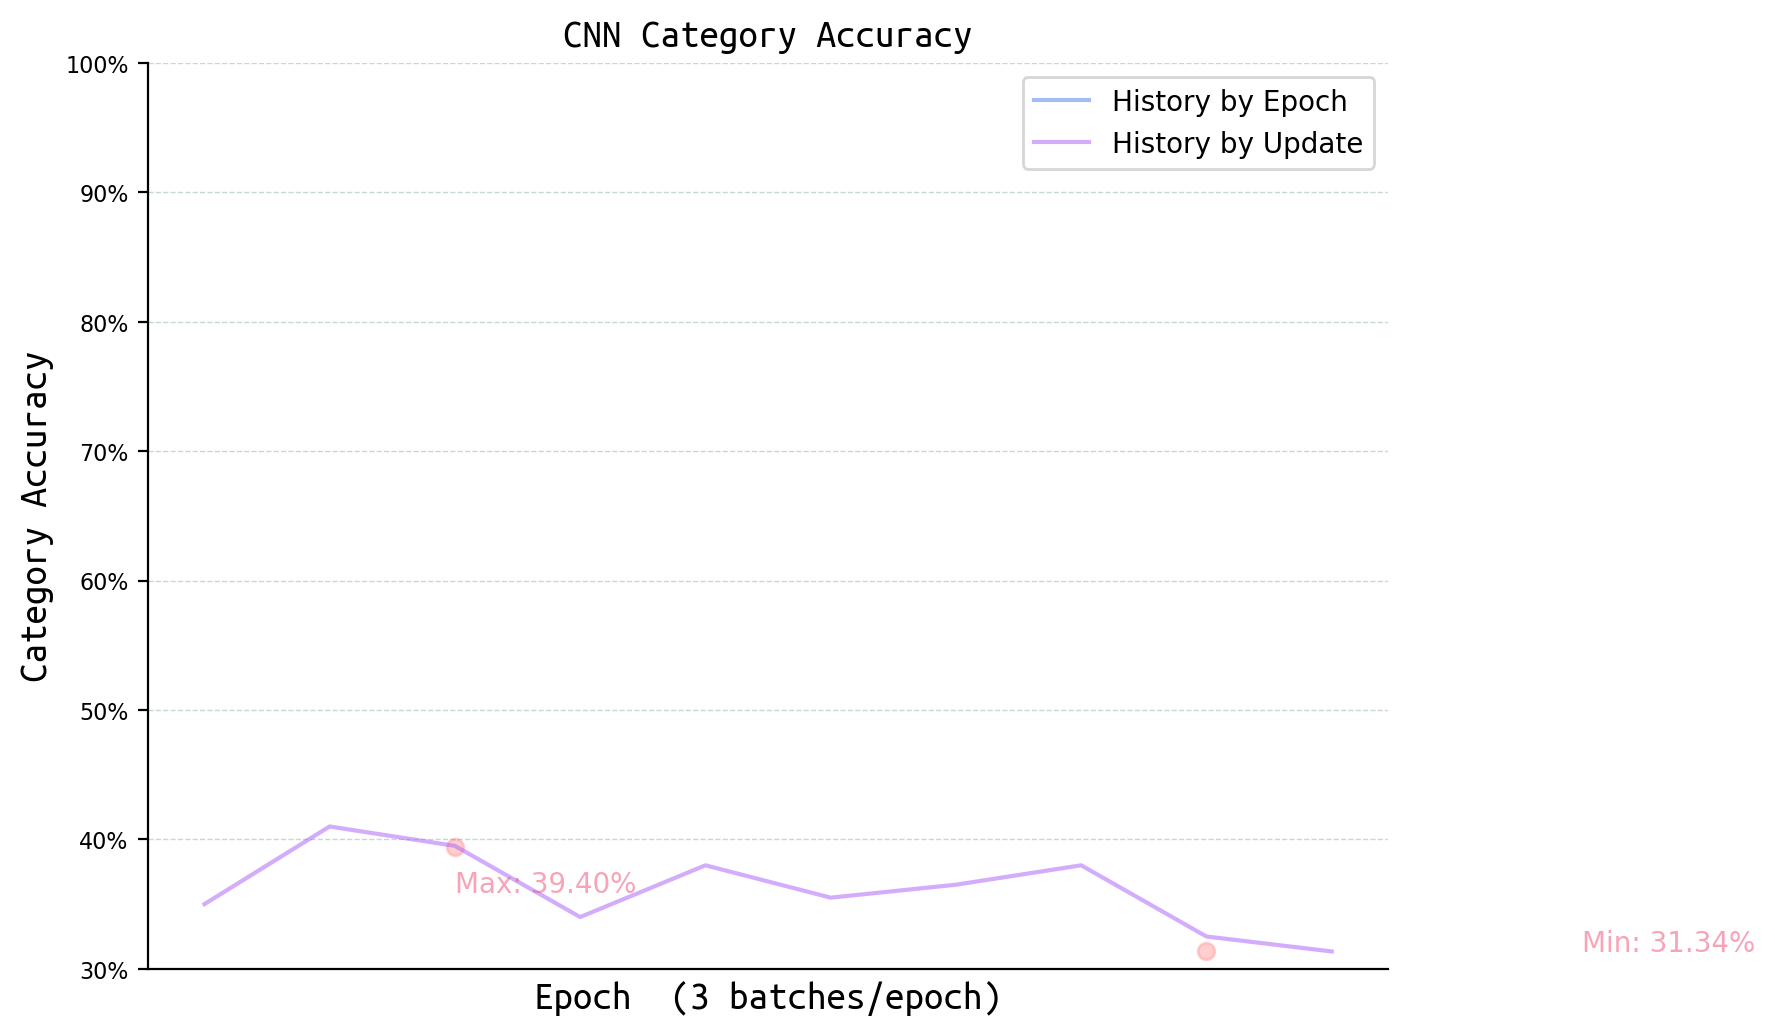

In [50]:
epoch_history = model_cnn.epoch_history_accuracy
update_history = model_cnn.update_history_accuracy

fig, ax = plot_cat_acc(epoch_history, update_history, 3, 'CNN Category Accuracy')
plt.show()